# Sentiment Analysis with CLS Token from BERT with SST Malay Dataset 

SST dataset had been translated using Google translate API. Google Translate is using Transformer. Ref: https://ai.googleblog.com/2020/06/recent-advances-in-google-translate.html


We will train with SST dataset and test on our very own dataset 

#### The new dataset had been labeled by author into three classes with following criteria:
- Class "0" = Negative (Complaints, sad)
- Class "1" = Neutral (Instuction, statement, share experience)
- Class "2" = Positive (Motivation, happy)

In [1]:
#import necessary library & settings
import torch
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00 ", "#FF006D", "#ADFF02", "#8F00FF"]
#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
warnings.filterwarnings('ignore')

cuda:0


# Let's understand the classes distribution for SST dataset

### We select the first 8000 dataset for experiment

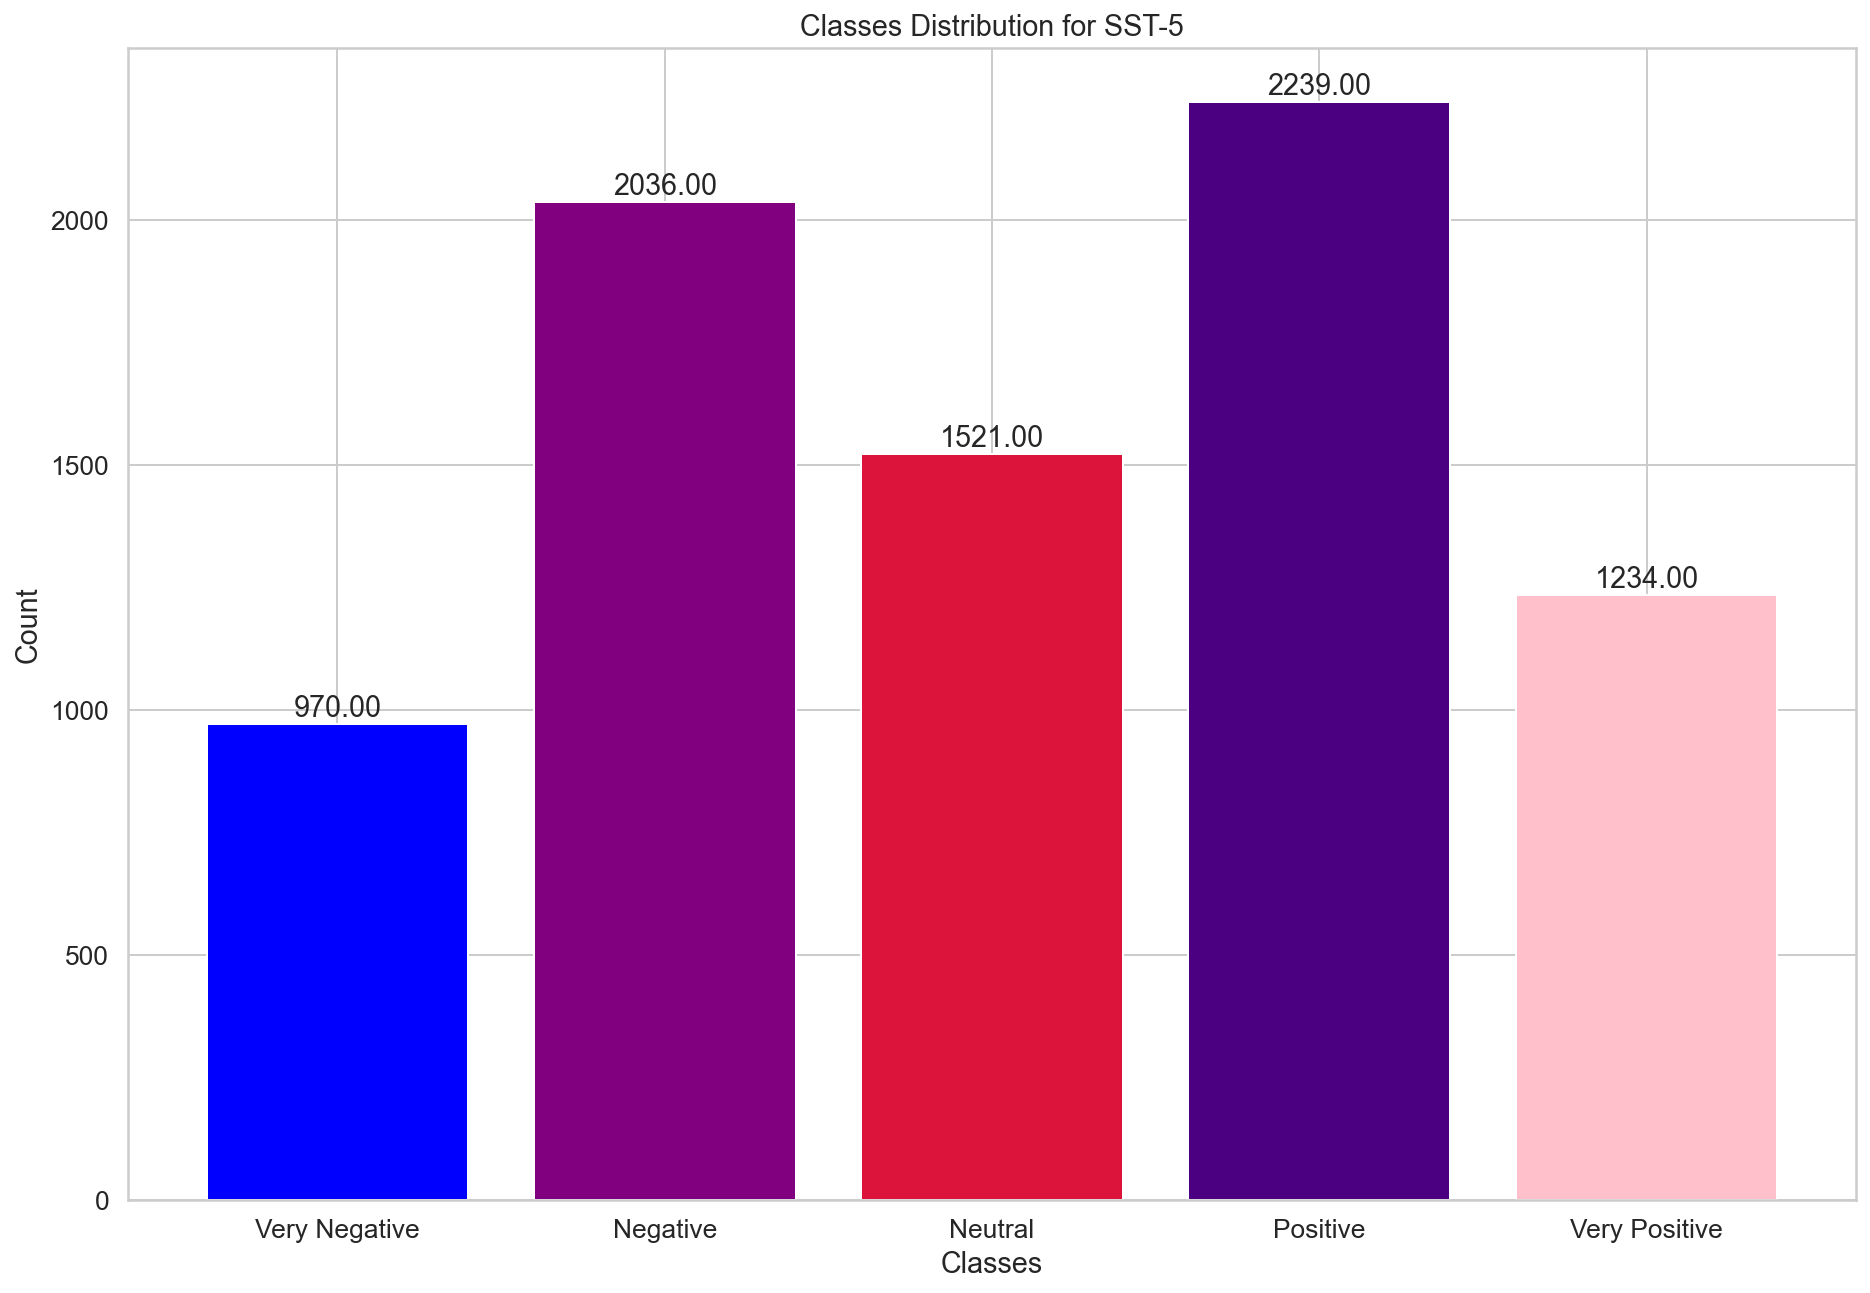

In [2]:
import pandas as pd
# Read train data
df = pd.read_csv('Desktop/sst-5_malay.csv', header=0, names=['sentence', 'label'],encoding='latin-1')
df = df[:8000]

Vnegative=0
negative=0
positive=0
Vpositive=0
neutral=0

for i in range (8000):
    #print(df['truth'][i])
    if(df['label'][i]==1):
        Vnegative=Vnegative+1
    elif(df['label'][i]==2):
        negative=negative+1
    elif(df['label'][i]==3):
        neutral=neutral+1
    elif(df['label'][i]==4):
        positive=positive+1
    elif(df['label'][i]==5):
        Vpositive=Vpositive+1

Classes = ['Very Negative','Negative','Neutral','Positive','Very Positive']
Count = [Vnegative,negative,neutral,positive,Vpositive]
fig = plt.figure()
ax = fig.add_axes([0,2,1,1])
ax.set_xlabel('Classes')
ax.set_ylabel('Count')
ax.set_title('Classes Distribution for SST-5')
width=0.35
x = np.arange(len(Count))
rects1 = ax.bar(x - width/2, Count, width)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 1, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
rects1 = ax.bar(x - width/2, Count, width)
autolabel(rects1)
ax.bar(Classes,Count,color=[ 'blue', 'purple', 'crimson','indigo','pink'])
plt.show()

#### We want only 3 classes, so we will combine related classes

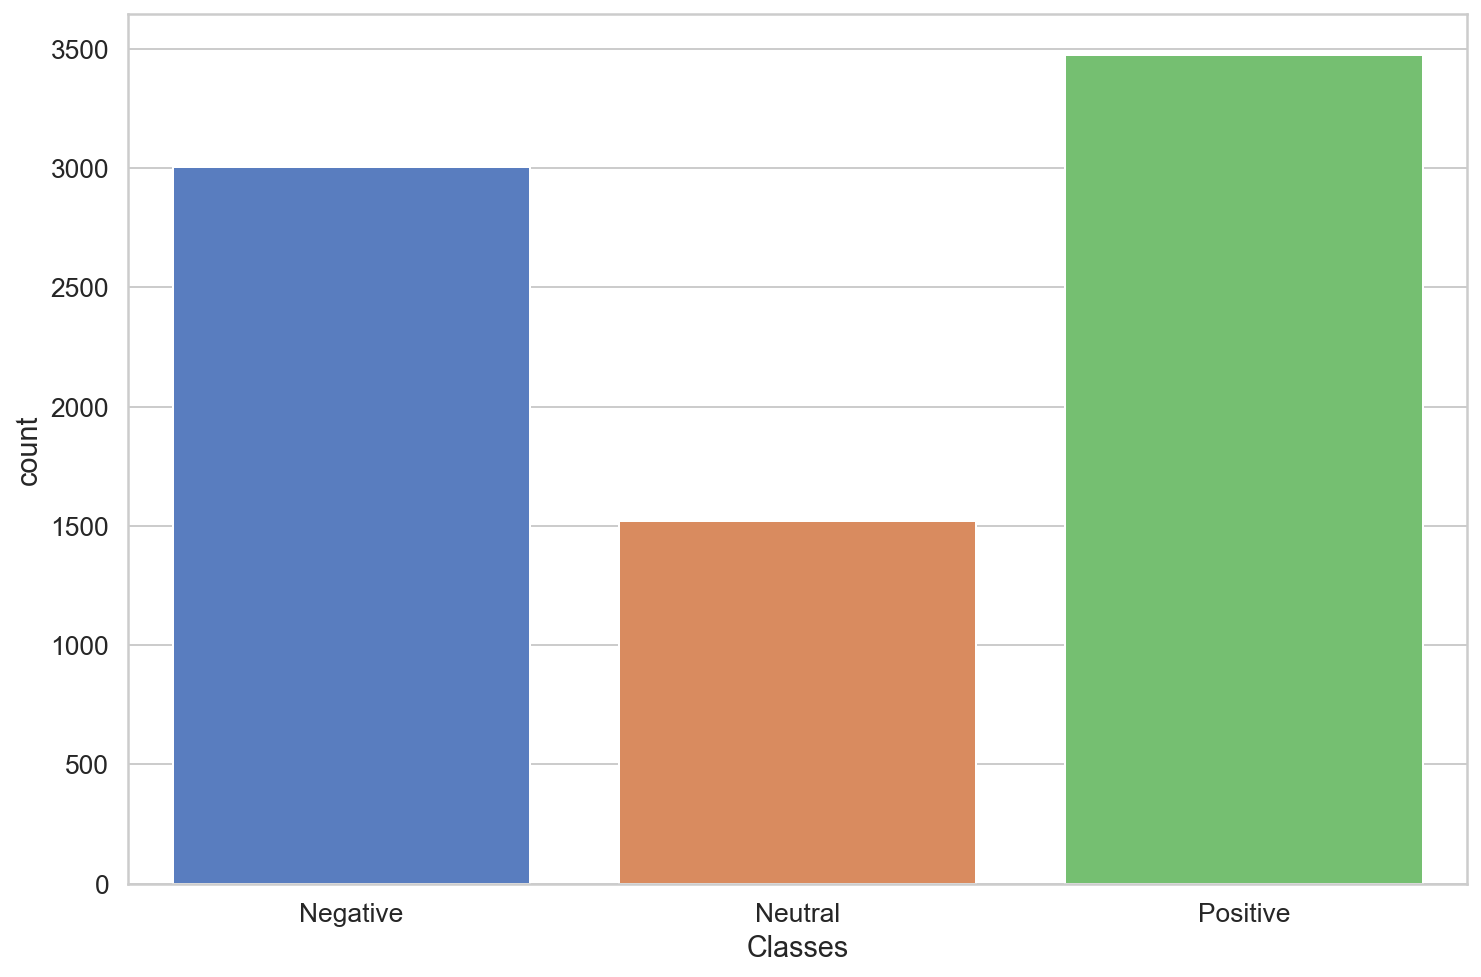

In [3]:
def to_sentiment(rating):
  rating = int(rating)
  if rating == 1:
    return 0
  elif rating == 2:
    return 0
  elif rating == 3:
    return 1
  elif rating == 4:
    return 2
  else:
    return 2
df['label'] = df.label.apply(to_sentiment)
class_names = ['Negative','Neutral','Positive']
ax = sns.countplot(df.label)
plt.xlabel('Classes')
ax.set_xticklabels(class_names);


## Now, we load BERT and put it into GPU

In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [5]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [6]:
class_names = ['Negative','Neutral', 'Positive']
#model = SentimentClassifier(len(class_names))
model = bert_model.to(device)

#### We obtain the CLS token from BERT for every sentence in the dataset as our embeddings and saved into "encoded"

In [7]:
#extract CLS token for every sentence
encoded=[]
for i in range (0,len(df['sentence'])):
    encoded_review = tokenizer.encode_plus(
      df['sentence'][i],
      max_length=512,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    feature = last_hidden_states
    features = (feature[0][:,0,:].cpu()).numpy().flatten() #extract the last CLS token from BERT-layer and flatten into 1d array
    encoded.append(features)

    

#### Don't forget to pass the sentiment to labels

In [8]:
labels=df['label']

# Classifier Training
#### Let's us split the dataset now

In [9]:
train_features, test_features, train_labels, test_labels = train_test_split(encoded, labels)

#### Let's try with various classifiers to see which one perform better

In [10]:
lr_clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   n_jobs=None, penalty='l2',
                   random_state=None, tol=0.0001, verbose=0,
                   warm_start=False)
lr_clf.fit(train_features, train_labels)
lr_score=lr_clf.score(test_features, test_labels)
lr_score

0.514

In [11]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
dt_clf = dt_clf.fit(train_features,train_labels)
dt_score=dt_clf.score(test_features, test_labels)
dt_score

0.383

In [12]:
from sklearn.neural_network import MLPClassifier
MLP_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

MLP_clf.fit(train_features,train_labels)
MLP_score=MLP_clf.score(test_features, test_labels)
MLP_score

0.4355

In [13]:
from sklearn.neighbors import KNeighborsClassifier
kn_clf = KNeighborsClassifier(n_neighbors=3)
kn_clf.fit(train_features,train_labels)
kn_score=kn_clf.score(test_features, test_labels)
kn_score

0.4335

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svc_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc_clf.fit(train_features,train_labels)
svc_score=svc_clf.score(test_features, test_labels)
svc_score

0.5105

In [15]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)
gpc_clf = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(train_features,train_labels)
gpc_score=gpc_clf.score(test_features, test_labels)
gpc_score

0.4355

In [16]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(train_features,train_labels)
gnb_score=gnb_clf.score(test_features, test_labels)
gnb_score

0.399

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
train_features2,train_labels2 = make_classification(n_samples=8000, n_features=768,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
ab_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
ab_clf.fit(train_features2,train_labels2)
ab_score=ab_clf.score(test_features, test_labels)
ab_score

0.2105

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#train_features,train_labels = make_classification(n_samples=5000, n_features=768,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(train_features2,train_labels2)
rf_score=rf_clf.score(test_features, test_labels)
rf_score

0.2095

In [19]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
hgb_clf = HistGradientBoostingClassifier().fit(train_features2,train_labels2)
hgb_score=hgb_clf.score(test_features, test_labels)
hgb_score

0.2045

In [20]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
#train_features,train_labels = make_classification(n_samples=5000, n_features=768,
 #                           n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(train_features2,train_labels2)
gb_score=gb_clf.score(test_features, test_labels)
gb_score

0.205

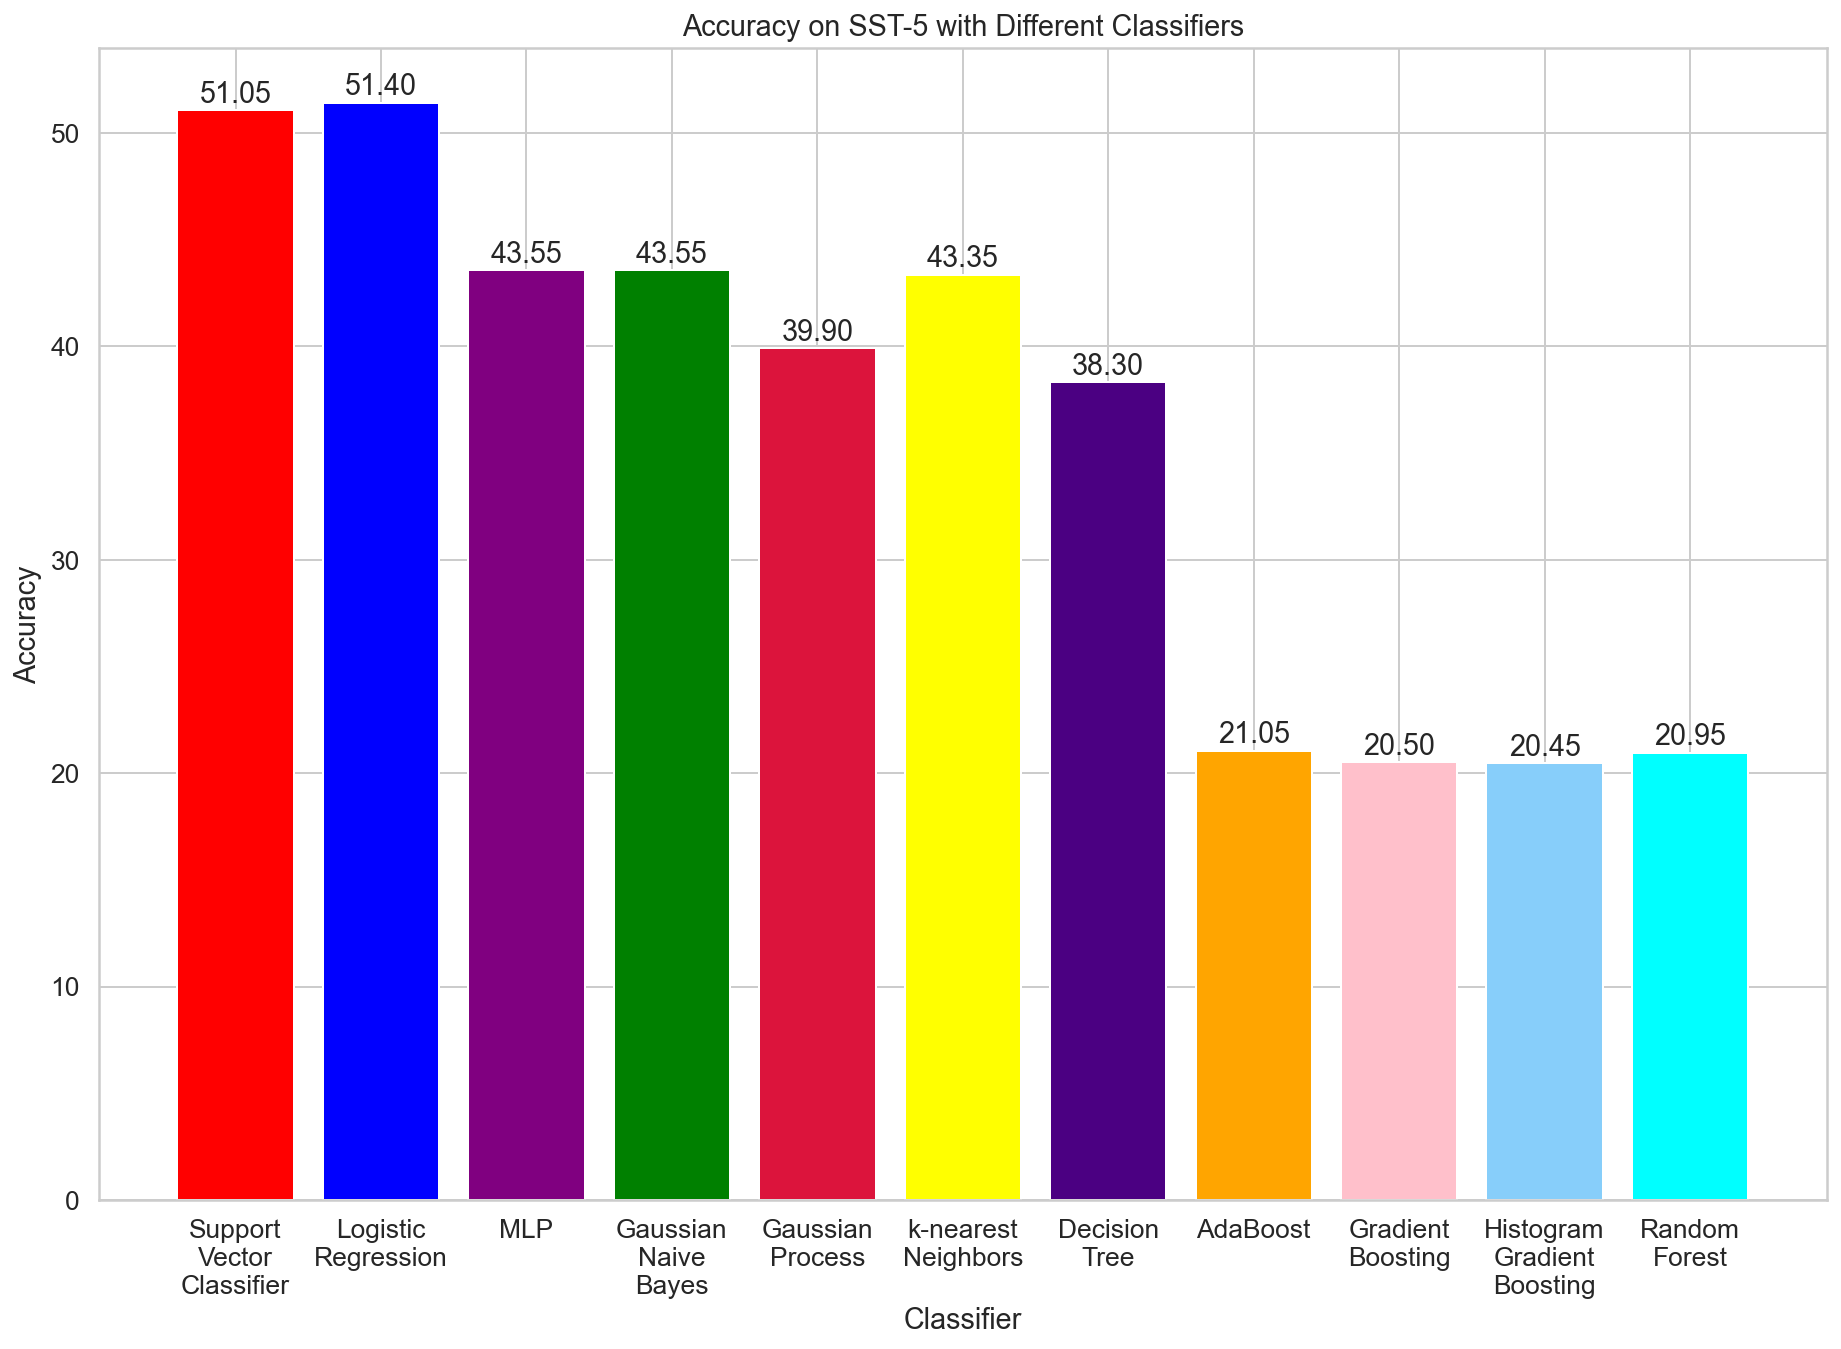

In [21]:
Classifier = ['Support\nVector\nClassifier', 'Logistic\nRegression', 'MLP','Gaussian\nNaive\nBayes','Gaussian\nProcess', 'k-nearest\nNeighbors', 'Decision\nTree','AdaBoost','Gradient\nBoosting','Histogram\nGradient\nBoosting','Random\nForest']
Accuracy = [svc_score*100,lr_score*100,MLP_score*100,gpc_score*100,gnb_score*100,kn_score*100,dt_score*100,ab_score*100,gb_score*100,hgb_score*100,rf_score*100]
fig = plt.figure()
ax = fig.add_axes([0,2,1,1])
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy on SST-5 with Different Classifiers')
width=0.35
x = np.arange(len(Accuracy))
rects1 = ax.bar(x - width/2, Accuracy, width)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 1, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
rects1 = ax.bar(x - width/2, Accuracy, width)
autolabel(rects1)
ax.bar(Classifier,Accuracy,color=['red', 'blue', 'purple', 'green', 'crimson','yellow','indigo','orange','pink','lightskyblue','aqua'])
plt.show()

#### Hooray! We can see Support Vector Classifier performs the best! For comparison, we will use Support Vector Classifier as our classifier.

# Let's do some simple testing

In [29]:
text='saya sangat gembira.'
encoded_review = tokenizer.encode_plus(
  text,
  max_length=100,
  truncation=True,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
feature = last_hidden_states
features = (feature[0][:,0,:].cpu()).numpy()
prediction=int(svc_clf.predict(features))
print(prediction)
print(f'Sentiment  : {class_names[prediction]}')

2
Sentiment  : Positive


## Let's load our english dataset now

In [23]:
df_test=pd.read_csv('Desktop/dataset-en.csv',header=0, names=['sentence', 'label'],encoding='latin-1')
df_test.head()

,sentence,label
0,"\tAs a front liner of my family, as a teacher...",0
1,Explore your spiritual core. By exploring you...,1
2,Face your fears and take action. Tackling you...,1
3,I am the mother of four children. The childre...,0
4,"Lastly, although I encountered a lot of chall...",2


## We get the embedding from BERT for every sentence

The sentence will be tokenized with maximum length= 512, any sentence's embedding more than 512 tokens will be cut off before feeding into BERT to get the final CLS token

In [24]:
#extract CLS token for every sentence
match=0
false=0
for i in range (0,len(df_test['sentence'])):
    encoded_review = tokenizer.encode_plus(
      df_test['sentence'][i],
      max_length=512,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    feature = last_hidden_states
    features = (feature[0][:,0,:].cpu()).numpy() #extract the last CLS token from BERT-layer
    prediction=int(svc_clf.predict(features))
    #print('Label:',prediction)
    #print(f'Sentiment  : {class_names[prediction]}')
    if (df_test['label'][i]==prediction):
        match+=1
    elif(df_test['label'][i]!=prediction):
        false+=1
accuracy=((len(df_test['sentence'])-false)/len(df_test['sentence']))*100
print('Accuracy:',accuracy,'%')
        

Accuracy: 26.717557251908396 %


#### We obtained 26.71% accuracy for english dataset even we trained using SST (Malay) 

## Let's try with our Malay dataset

In [25]:
df_test_malay=pd.read_csv('Desktop/dataset-malay.csv',header=0, names=['sentence', 'label'],encoding='latin-1')
df_test_malay.head()

,sentence,label
0,\tKesihatan mental dan fizikal merupakan perk...,2
1,"\tSeterusnya, dengan kekal berada di rumah da...",1
2,Semasa diketahui guru perlu menjalankan PdPC ...,2
3,Selepas sudah menyesuaikan diri dengan keadaan...,2
4,\tAmalan gaya hidup sihat perlu dijadikan buda...,2


In [26]:
#extract CLS token for every sentence
match=0
false=0
i=0
for i in range (0,len(df_test_malay['sentence'])):
    encoded_review = tokenizer.encode_plus(
      df_test_malay['sentence'][i],
      max_length=512,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    feature = last_hidden_states
    features = (feature[0][:,0,:].cpu()).numpy() #extract the last CLS token from BERT-layer
    prediction=int(svc_clf.predict(features))
    #print('Label:',prediction)
    #print(f'Sentiment  : {class_names[prediction]}')
    if (df_test_malay['label'][i]==prediction):
        match+=1
    elif(df_test_malay['label'][i]!=prediction):
        false+=1
accuracy=((len(df_test_malay['sentence'])-false)/len(df_test_malay['sentence']))*100
print('Accuracy:',accuracy,'%')
        

Accuracy: 35.388739946380696 %


#### We got 35.39% accuracy for malay dataset.

## Let's try with english + malay dataset

In [27]:
df_test_mix=pd.read_csv('Desktop/dataset-mix.csv',header=0, names=['sentence', 'label'],encoding='latin-1')
df_test_mix.head()

,sentence,label
0,"\tAs a front liner of my family, as a teacher...",0
1,Explore your spiritual core. By exploring you...,1
2,Face your fears and take action. Tackling you...,1
3,I am the mother of four children. The childre...,0
4,"Lastly, although I encountered a lot of chall...",2


In [28]:
#extract CLS token for every sentence
match=0
false=0
i=0
for i in range (0,len(df_test_mix['sentence'])):
    encoded_review = tokenizer.encode_plus(
      df_test_mix['sentence'][i],
      max_length=512,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    feature = last_hidden_states
    features = (feature[0][:,0,:].cpu()).numpy() #extract the last CLS token from BERT-layer
    prediction=int(svc_clf.predict(features))
    #print('Label:',prediction)
    #print(f'Sentiment  : {class_names[prediction]}')
    if (df_test_mix['label'][i]==prediction):
        match+=1
    elif(df_test_mix['label'][i]!=prediction):
        false+=1
accuracy=((len(df_test_mix['sentence'])-false)/len(df_test_mix['sentence']))*100
print('Accuracy:',accuracy,'%')

Accuracy: 31.761006289308174 %


#### We obtained 31.76% accuracy for mix language dataset even we trained our classifier on malay only!